## CS 5304: Assignment 2
### Lixuan Mao (lm769)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kurtosis
from scipy.stats import skew
from collections import Counter
from sklearn import preprocessing

# 1. Partitioning the Data
Use `random.sample` to randomly sample 2 millions row ids out of 48 millions row.

Then, partition them into three parts: train(1M), validation(250K), test(750K).

In [132]:
selected_indice = random.sample(range(0, int(48e6)), int(2e6))

train_ids = set(selected_indice[0:int(1e6)])
validation_ids = set(selected_indice[int(1e6):int(1e6+250e3)])
test_ids = set(selected_indice[int(1e6+250e3):])

The following codes are used to write `train_ids, validation_ids, test_ids` into separated text files.

In [133]:
train_ids_file = open('train_ids.txt','w')
validation_ids_file = open('validation_ids.txt','w')
test_ids_file = open('test_ids.txt','w')

train_ids_str = [str(i) for i in train_ids]
validation_ids_str = [str(i) for i in validation_ids]
test_ids_str = [str(i) for i in test_ids]

train_ids_file.write('\n'.join(train_ids_str))
validation_ids_file.write('\n'.join(validation_ids_str))
test_ids_file.write('\n'.join(test_ids_str))

test_ids_file.close()
validation_ids_file.close()
train_ids_file.close()

# 2. Summary Statistics
The following section is used to compute histograms and display them.

Basically, I wrote two functions to compute hisograms for numerical and cetrgorical features respectively.

For numerical features, firstly, use `numpy.histogram` to compute the **density** and **weights** of the histogram given certain number of bins.
Then one can manually set the width of the bins of the histogram as well as the center of each bin.
Finally, use `matplotlib.pyplot.bar` to draw the histogram.
PS, I also calculate and display some summary statistics for the numerical features.

For categorical features, firstly, use `collections.Counter` to calculate the frequency of each categorical value of that feature. Because some features may have a very large number of unique categorical values, here I only pick the most frequent 100 categorical values to display in the histogram.
After getting the frequency of each categorical value and pick the most frequent 100, we can still use `matplotlib.pyplot.bar` to draw the histogram.

The histograms of the 39 features are shown as follow.


Feature  0
mean, standard deviation, skew, kurtosis:
 (1.8376969999999999, 7.1471233889020702, 32.84501831334796, 5536.904517188818)


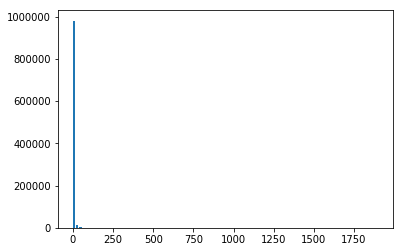

Feature  1
mean, standard deviation, skew, kurtosis:
 (101.127129, 380.35779217365513, 7.094944987899882, 73.99907727619193)


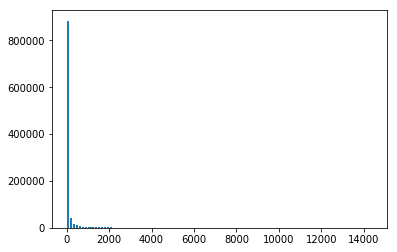

Feature  2
mean, standard deviation, skew, kurtosis:
 (20.443393, 347.4359542040051, 86.10120995869441, 9281.740471831203)


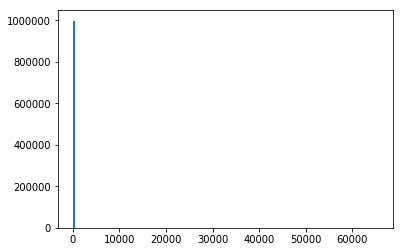

Feature  3
mean, standard deviation, skew, kurtosis:
 (5.4639049999999996, 8.1854045196908274, 3.7287961772607603, 63.12491237363963)


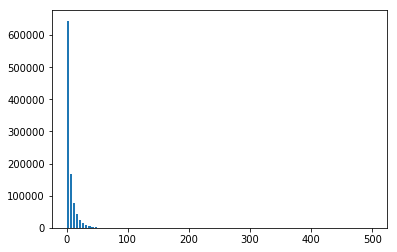

Feature  4
mean, standard deviation, skew, kurtosis:
 (17315.993042999999, 67974.722457699667, 9.947274606288218, 144.505734565931)


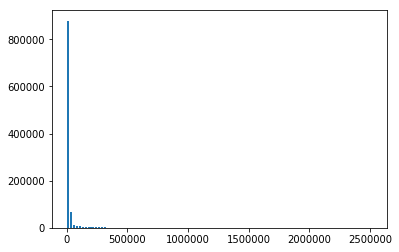

Feature  5
mean, standard deviation, skew, kurtosis:
 (85.72842, 285.55662329965946, 27.59700766571596, 2704.2249233261714)


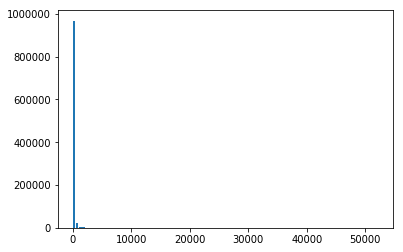

Feature  6
mean, standard deviation, skew, kurtosis:
 (14.940308, 61.345383435635469, 24.428309222283417, 1292.56943093399)


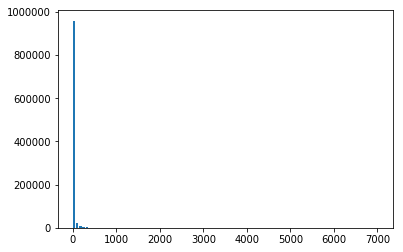

Feature  7
mean, standard deviation, skew, kurtosis:
 (11.938719000000001, 16.6550523757519, 72.85228710381033, 17537.658313476113)


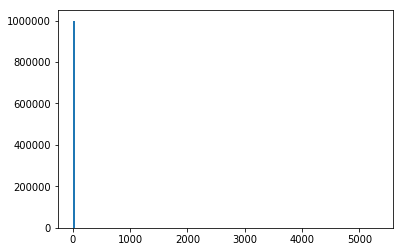

Feature  8
mean, standard deviation, skew, kurtosis:
 (96.873530000000002, 211.96366974870742, 8.589300282348093, 171.95233682383932)


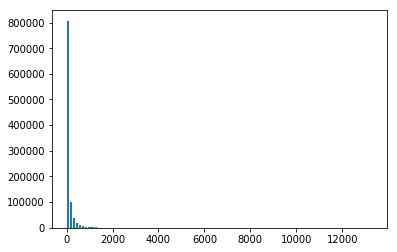

Feature  9
mean, standard deviation, skew, kurtosis:
 (0.32252900000000001, 0.58349125456942363, 2.0480730835089513, 5.549978668541556)


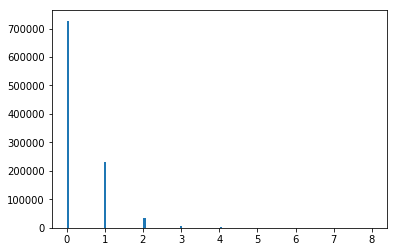

Feature  10
mean, standard deviation, skew, kurtosis:
 (2.5011570000000001, 5.0448546719753002, 6.268530853956374, 64.04359279438766)


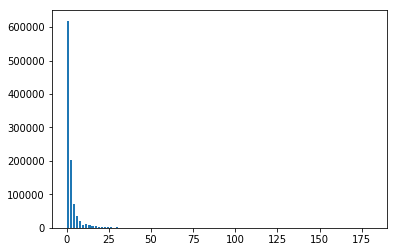

Feature  11
mean, standard deviation, skew, kurtosis:
 (0.22716, 2.7107221057127928, 51.61525748487304, 5537.542022626471)


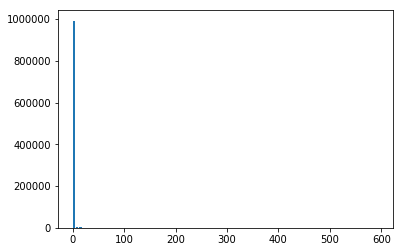

Feature  12
mean, standard deviation, skew, kurtosis:
 (6.134423, 14.076104981743741, 97.23930937086678, 23812.286060732826)


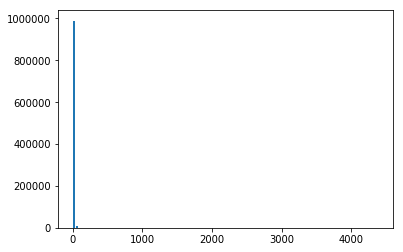

Feature  13


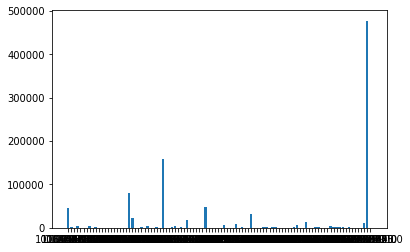

Feature  14


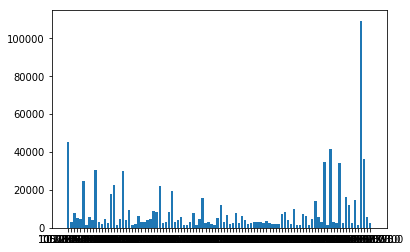

Feature  15


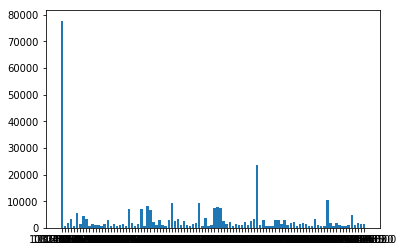

Feature  16


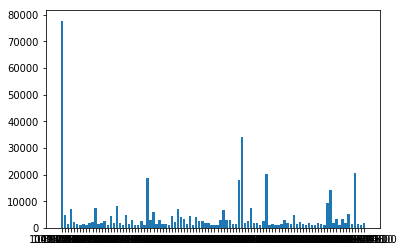

Feature  17


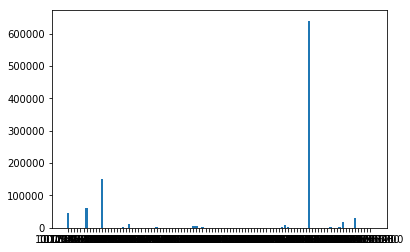

Feature  18


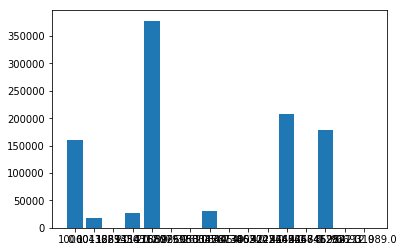

Feature  19


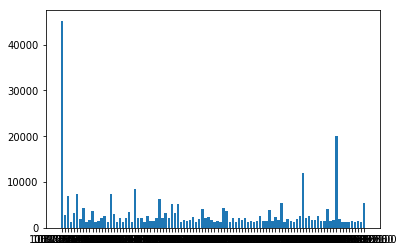

Feature  20


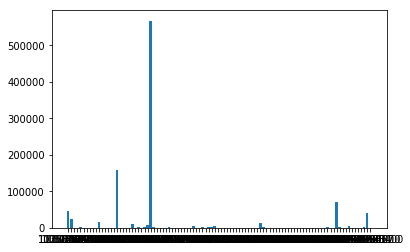

Feature  21


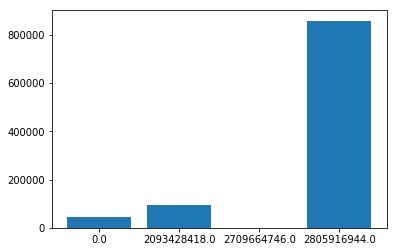

Feature  22


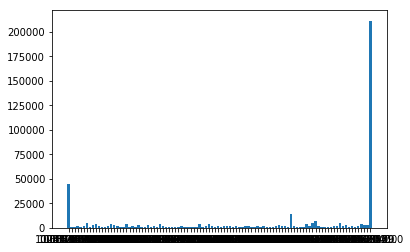

Feature  23


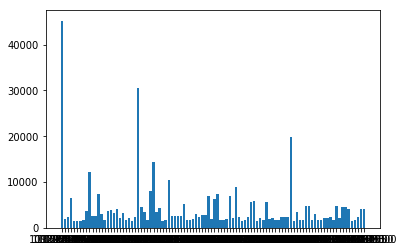

Feature  24


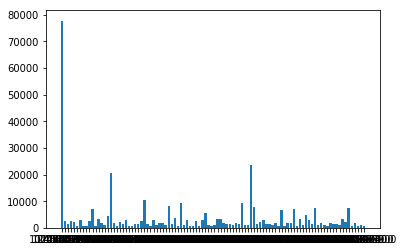

Feature  25


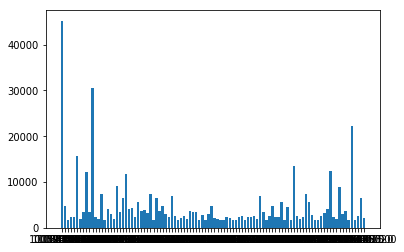

Feature  26


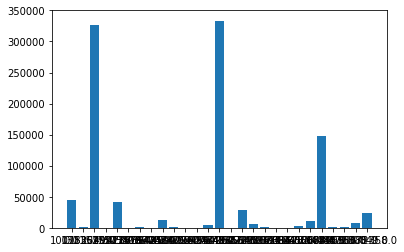

Feature  27


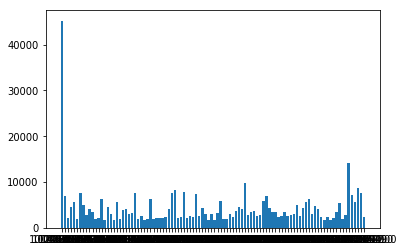

Feature  28


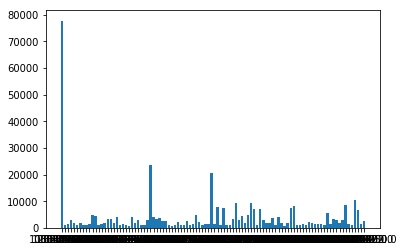

Feature  29


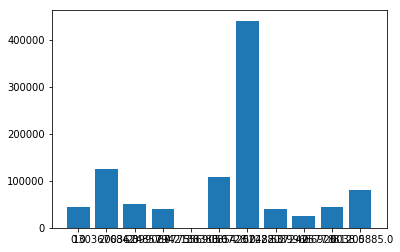

Feature  30


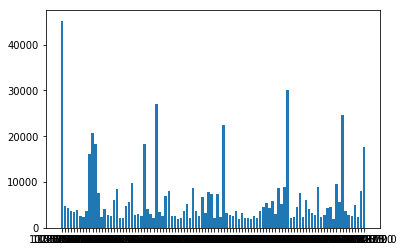

Feature  31


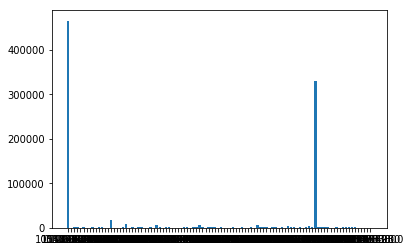

Feature  32


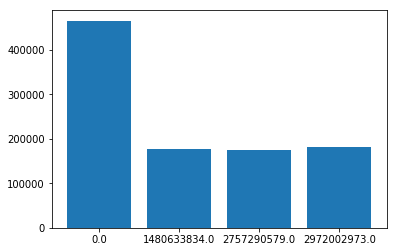

Feature  33


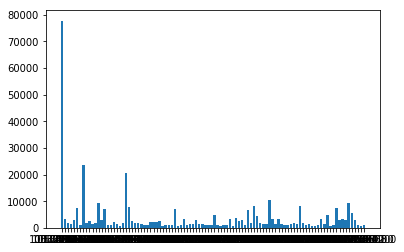

Feature  34


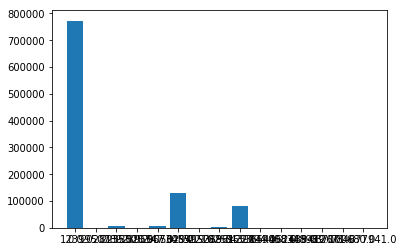

Feature  35


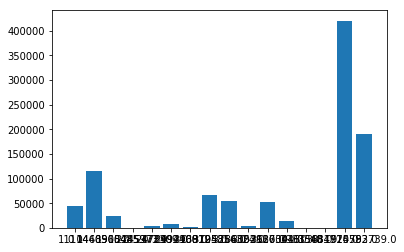

Feature  36


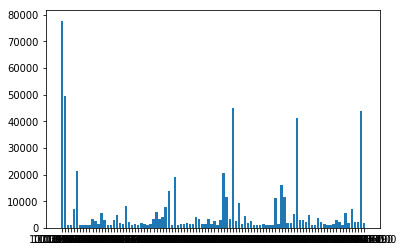

Feature  37


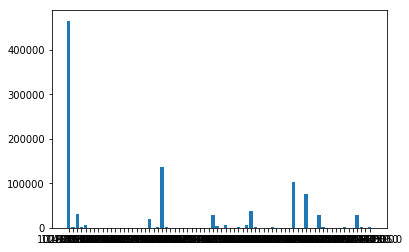

Feature  38


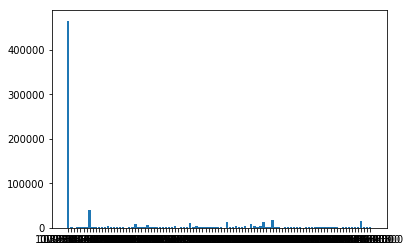

In [29]:
def showHistgram_numerical(data):
    hist, bins = np.histogram(data, bins=100)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()
    
def showHistgram_categorical(data):
    counter = Counter(data)
    names = [str(entry[0]) for entry in counter.most_common(100)]
    values = [entry[1] for entry in counter.most_common(100)]
    plt.bar(names,values)
    plt.show()
    
def calStatsData(data):
    return np.mean(data),np.std(data),skew(data),kurtosis(data)
    
for i in range(0,39):
    print("Feature ", i)
    if i<13:
        print("mean, standard deviation, skew, kurtosis:\n",calStatsData(train_data[:,i]))
        showHistgram_numerical(train_data[:,i])
    else:
        showHistgram_categorical(train_data[:,i])


# 3. Categorical Feature Selection

For each categorical feature, I first calculate the frequency for each unique value. After this calculation, I find that some categories have a very large amount of unique values, which may result in a very sparse matrix when doing one-hot transformation.

Therefore, the next thing I do is to reduce the number of unique values for each category so as to get a better one-hot transformation. For each category, I sort its unique values descendingly according to their frequencies and select those unique values that have highest frequencies and take up more than `threshold = 90%` of the training data. These unique values form `the most common categorical value set` for each category.

In [33]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
categorical_feature_val_sets = [getMostCommonCatVals(train_data[:,i]) for i in range(13,39)]
pp.pprint([(i+13,len(j)) for i,j in enumerate(categorical_feature_val_sets)])

[   (13, 17),
    (14, 180),
    (15, 325036),
    (16, 113909),
    (17, 5),
    (18, 15),
    (19, 4796),
    (20, 9),
    (21, 3),
    (22, 7992),
    (23, 2033),
    (24, 287359),
    (25, 1525),
    (26, 6),
    (27, 2254),
    (28, 214514),
    (29, 10),
    (30, 837),
    (31, 1827),
    (32, 3),
    (33, 256887),
    (34, 14),
    (35, 15),
    (36, 21816),
    (37, 71),
    (38, 31964)]


After the operation described above, one can see that some categories still have a large number of unique values in their `most common categorical value sets`. The categorical feature which has more than `threshold = 20` unique in its `most common categorical value set` is then dropped, otherwise, it is retained.

The reason why I do this is that a too large `most common categorical value set` will result in a very sparse feature matrix while doing one-hot transformation, which could lead to bad results in the following model training process. Additionally, if the `most common categorical value set` of a categorical feature is large, it tells us that the unique values in this feature spread quite evenly, which implies that the unique values of this feature may not be very representative. Therefore, I use this criterion to select the categorical features.

The categorical features that survive the selection are:
```
13, 17, 18, 20, 21, 26, 29, 32, 34, 35
```

The following snippet demonstrates the histograms of the selected categorical features given the `most common categorical value set`s. 


'The frequency of each unique value is:'
{   '1106095165.0': 3479,
    '1134183588.0': 3201,
    '1520359856.0': 79676,
    '1543146165.0': 22839,
    '164236161.0': 4526,
    '1761418852.0': 159315,
    '1974218726.0': 3933,
    '2270503831.0': 16977,
    '2364568165.0': 47217,
    '2592715628.0': 7567,
    '2927815201.0': 8576,
    '3193477969.0': 31782,
    '402035541.0': 6013,
    '4101224668.0': 13521,
    '605374176.0': 5185,
    '967779847.0': 10514,
    '98275684.0': 477366,
    'None': 98313}


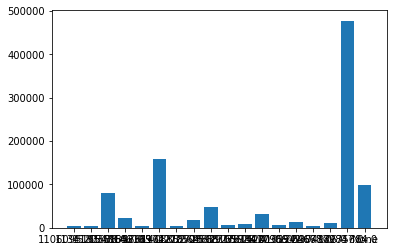

'The frequency of each unique value is:'
{   '1135711049.0': 60687,
    '1291264903.0': 149784,
    '633879704.0': 640417,
    '814759540.0': 18361,
    '944272590.0': 31254,
    'None': 99497}


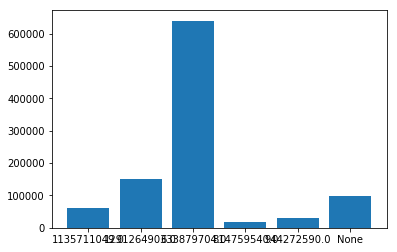

'The frequency of each unique value is:'
{   '1006043623.0': 17237,
    '1011281330.0': 12,
    '1869454312.0': 27242,
    '2114768079.0': 378085,
    '2186965080.0': 1,
    '3226958037.0': 87,
    '326208445.0': 30394,
    '3345673462.0': 54,
    '3813803042.0': 170,
    '4059225645.0': 23,
    '4222442646.0': 208249,
    '4260457412.0': 12,
    '4268462821.0': 178000,
    '85954212.0': 2,
    '966931989.0': 1,
    'None': 160431}


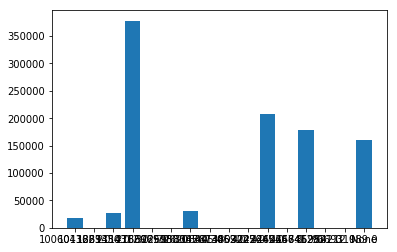

'The frequency of each unique value is:'
{   '103503145.0': 24850,
    '1373072062.0': 16894,
    '1530472565.0': 158603,
    '1683111162.0': 9215,
    '1816257374.0': 6860,
    '185940084.0': 567152,
    '3369981076.0': 11945,
    '529118562.0': 71544,
    '937732754.0': 39729,
    'None': 93208}


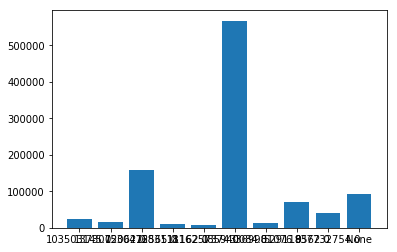

'The frequency of each unique value is:'
{   '2093428418.0': 96423,
    '2709664746.0': 162,
    '2805916944.0': 858190,
    'None': 45225}


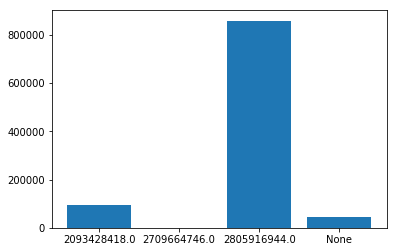

'The frequency of each unique value is:'
{   '131152527.0': 326741,
    '1690912869.0': 42239,
    '2995026422.0': 333410,
    '3488554025.0': 29385,
    '450684655.0': 148274,
    '85072358.0': 23084,
    'None': 96867}


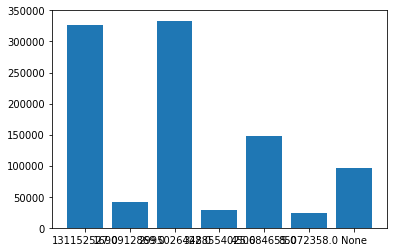

'The frequency of each unique value is:'
{   '130367684.0': 124798,
    '2003624857.0': 50195,
    '2399067775.0': 40999,
    '2942138380.0': 33,
    '3569056728.0': 109204,
    '3854202482.0': 440871,
    '512280399.0': 40684,
    '537242577.0': 24577,
    '666926038.0': 43664,
    '881205885.0': 79750,
    'None': 45225}


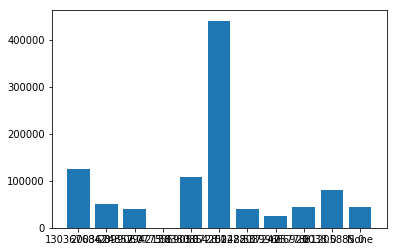

'The frequency of each unique value is:'
{   '1480633834.0': 177934,
    '2757290579.0': 175344,
    '2972002973.0': 181061,
    'None': 465661}


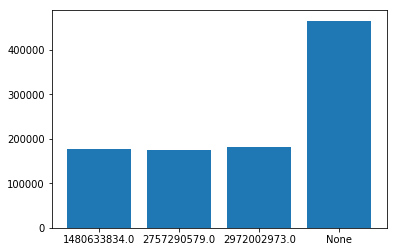

'The frequency of each unique value is:'
{   '1239950789.0': 110,
    '2028135305.0': 6924,
    '2253520347.0': 200,
    '2395567348.0': 5049,
    '2905629419.0': 130350,
    '305595269.0': 1,
    '3221625965.0': 3780,
    '3386122794.0': 80499,
    '3439149058.0': 205,
    '3654162488.0': 2,
    '408348989.0': 1,
    '619412671.0': 1,
    '687100680.0': 13,
    '784677941.0': 2,
    'None': 772863}


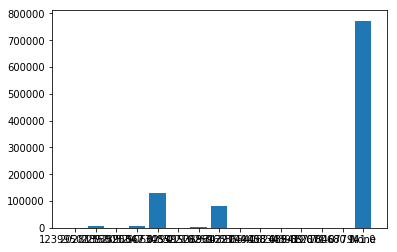

'The frequency of each unique value is:'
{   '1111468905.0': 115164,
    '1440560485.0': 23075,
    '1918445973.0': 100,
    '2245372309.0': 3452,
    '2478494400.0': 8090,
    '2992939104.0': 1030,
    '3168725356.0': 66261,
    '3195814324.0': 53790,
    '3286002927.0': 4298,
    '3353110304.0': 53288,
    '3686041303.0': 14427,
    '3983348.0': 2,
    '635684715.0': 94,
    '851920782.0': 420503,
    '974593739.0': 191201,
    'None': 45225}


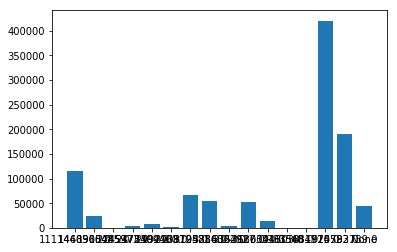

In [47]:
def showCatHistgramGivenValueset(data, valSet):
    counter = Counter(data)
    counter_valueSet = {'None':0}
    for entry in counter.items():
        if entry[0] in valSet:
            counter_valueSet[str(entry[0])] = entry[1]
        else:
            counter_valueSet['None'] += entry[1]
    pp.pprint("The frequency of each unique value is:")
    pp.pprint(counter_valueSet)
    plt.bar(counter_valueSet.keys(), counter_valueSet.values())
    plt.show()


selected_cats = [13, 17, 18, 20, 21, 26, 29, 32, 34, 35]
for cat in selected_cats:
    showCatHistgramGivenValueset(train_data[:,cat], getMostCommonCatVals(train_data[:,cat]))